### **Zadanie 1 úloha 2**

__Lukáš Bugaj__


__Adrián Maslák__

50/50

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy.stats import iqr
from scipy import stats
import re

### Import datasetov

In [3]:
observation_df = pd.read_csv("069/observation.csv", sep='\t')
station_df = pd.read_csv("069/station.csv", sep='\t')
patient_df = pd.read_csv("069/patient.csv",sep = '\t', engine = "python")

## 1.2-A identifikácia a počiatočné riešenie problémov s dátami

V tomto kroku budeme analyzovať datasety a identifikovať jednotlivé problémy s dátami. Budeme sa pozerať na chýbajúce hodnoty, hodnoty v zlom formáte a podobne. Na začiatok si špecifikujeme niektoré veci:

##### 1. Dátumy budeme očakávať vo formáte mm/dd/yyyy
##### 2.  Súradnice budeme očakávať v rozmedzí latitude <-90, 90> a longtitude <-180, 180>

Hneď pri pohľade na výpis hlavy datasetu si všimame že v stĺpci current_location je nesprávny formát dát.


In [55]:
patient_df.head()

,address,job,ssn,name,company,blood_group,mail,username,registration,residence,current_location,user_id,station_ID
0,"Vale Carvalho, 75\nGuaratã\n24749298 da Rocha ...",Serralheiro,91728604303,Samuel Mendes,Garcia,A+,sophie45@uol.com.br,olivia61,"07/02/2022, 00:00:00",NaN,"(Decimal('-9.834721'), Decimal('-166.061899'))",221,438
1,"6808 Gary Lodge\nRobertfort, AZ 39881",NaN,157-43-4132,Philip Lee,Castro-Nielsen,A-,nathanhoffman@gmail.com,nicholas13,2021-03-10,NaN,"(Decimal('-58.933888'), Decimal('16.122641'))",993,138
2,Drewesring 6-2\n31689 Gotha,NaN,439-87-8316,Ercan Kreusel B.A.,Bender Kruschwitz KG,A-,lia29@web.de,ludgerpergande,2021-12-15,NaN,"(Decimal('-23.3593505'), Decimal('-103.776206'))",349,562
3,NaN,NaN,BGOTLL14R61D690T,Fabia Vento,Prodi e figli,A+,ottavio30@yahoo.com,enricotognazzi,"06/06/2020, 00:00:00",NaN,"(Decimal('72.988397'), Decimal('-123.076931'))",461,541
4,"Vicolo Morandini, 44 Piano 8\n27027, Gropello ...",NaN,SCDLSE60D12F851B,Antonino Cavanna,Lattuada Group,A-,romana82@gmail.com,borsierecarla,03 Nov 2022,NaN,"(Decimal('-60.724837'), Decimal('-65.915593'))",1405,738


Tu je vidieť, že namiesto štandardnej polohy tu sú dáta v tvare (Decimal('-60.724837'), Decimal('-65.915593')), taktiež nieje úplne zrejmé ktorá je latitude a longtitude hneď na prvý pohľad. Ďalej sa pozrieme na dátumy a chýbajúce hodnoty a skontrolujeme aj hodnoty súradníc v station.csv.

Po skontrolovaní datasetov máme odhalené viaceré nedokonalosti, ako napríklad 3 chýbajúce hodnoty code v station.csv. V station.csv máme taktiež duplicity čo sa týka názvov staníc ale to nás nezaujíma, pretože stanica si robí revíziu viac krát v priebehu jej fungovania.

Ďalej čo sa týka datasetu patient.csv tam sme si už všimli nesprávny formát súradníc, ale chýbajú nám tam aj viaceré chýbajúce hodnoty, ako napríklad:
address              310
job                 1445
residence           2064
current_location     103

Taktiež nami stanovené kritériá na formát dátumu tento dataset nespĺňa ani v jednom riadku.
Počet neplatných dátumov v stĺpci 'registration' (očakávaný formát mm/dd/yyyy): 2064.

Pohľadom na analýzu datasetu station.csv nieje v tomto datasete žiadna chyba spôsobená zberom dát, čiže nemá žiadne chýbajúce hodnoty ani zlý formát.

In [4]:
def parse_date(date_str):
    if not isinstance(date_str, str):
        return pd.NaT

    if ',' in date_str:
        date_str = date_str.split(',')[0].strip()

    # Zoznam podporovaných formátov
    formats = [
        '%Y-%m-%d',      # YYYY-MM-DD (napr. 2021-03-10)
        '%Y/%m/%d',      # YYYY/MM/DD (napr. 2021/08/02)
        '%m/%d/%Y',      # MM/DD/YYYY (napr. 07/02/2022)
        '%d %b %Y',      # DD Mon YYYY (napr. 03 Nov 2022)
        '%d %B %Y'       # DD Month YYYY (napr. 03 August 2022)
    ]
    for fmt in formats:
        try:
            return pd.to_datetime(date_str, format=fmt)
        except:
            continue
station_df['revision'] = station_df['revision'].apply(parse_date).dt.strftime('%m/%d/%Y')
patient_df['registration'] = patient_df['registration'].apply(parse_date).dt.strftime('%m/%d/%Y')
station_df.to_csv('069/station.csv', index=False, sep='\t')
patient_df.to_csv('069/patient.csv', index=False, sep='\t')

Týmto skriptom sa nám úspešne podarilo eliminovať rôzne formáty dátumov v súbore.

In [8]:

def parse_date(date_str):
    try:
        if isinstance(date_str, str):
            # Kontrola formátu mm/dd/yyyy
            if re.match(r'^(0[1-9]|1[0-2])/(0[1-9]|[12][0-9]|3[01])/(\d{4})$', date_str):
                return pd.to_datetime(date_str, format='%m/%d/%Y', errors='coerce')
        return pd.NaT
    except:
        return pd.NaT

def identify_data_issues(df, dataset_name):
    print(f"\n### Analýza problémov v datasete: {dataset_name} ###")

    # Kontrola chybějících hodnot
    missing_values = df.isnull().sum()
    print("\nChýbajúce hodnoty:")
    print(missing_values[missing_values > 0])
    date_columns = []
    if dataset_name == "patient.csv" and 'registration' in df.columns:
        date_columns.append('registration')
    if dataset_name == "station.csv" and 'revision' in df.columns:
        date_columns.append('revision')

    non_date_columns = [col for col in df.columns if col not in date_columns]
    duplicates = df[non_date_columns].duplicated().sum() if non_date_columns else 0
    print(f"\nPočet duplicitných záznamov (ignorujúc dátumové stĺpce): {duplicates}")
    if duplicates > 0:
        print("Príklady duplicitných záznamov:")
        print(df[non_date_columns][df[non_date_columns].duplicated()].head())

    # Kontrola datumů pro konkrétní datasety
    if dataset_name in ["patient.csv", "observation.csv"]:
        for col in date_columns:
            df[col] = df[col].apply(parse_date)
            invalid_dates = df[col].isnull().sum()
            print(f"\nPočet neplatných dátumov v stĺpci '{col}' (očakávaný formát mm/dd/yyyy): {invalid_dates}")

    # Kontrola 'revision' pro station.csv
    if dataset_name == "station.csv" and 'revision' in df.columns:
        df['revision'] = df['revision'].apply(parse_date)
        inconsistent_dates = df['revision'].isnull().sum()
        print(f"\nPočet neplatných dátumov v stĺpci 'revision' (očakávaný formát mm/dd/yyyy: {inconsistent_dates}")

    # Kontrola formátu souřadnic
    if 'current_location' in df.columns:
        invalid_coords = df['current_location'].str.contains(r'[^\d\.\-\(\), ]', na=True).sum()
        print(f"\nPočet neplatných formátov súradníc: {invalid_coords}")

    # Kontrola platnosti zeměpisné šířky a délky
    if 'latitude' in df.columns and 'longitude' in df.columns:
        invalid_lat = df[(df['latitude'] < -90) | (df['latitude'] > 90)]['latitude'].count()
        invalid_lon = df[(df['longitude'] < -180) | (df['longitude'] > 180)]['longitude'].count()
        print(f"\nNeplatné zemepisné šírky: {invalid_lat}")
        print(f"Neplatné zemepisné dĺžky: {invalid_lon}")

print("=== Analýza datasetov ===")
identify_data_issues(station_df, "station.csv")
identify_data_issues(patient_df, "patient.csv")
identify_data_issues(observation_df, "observation.csv")

=== Analýza datasetov ===

### Analýza problémov v datasete: station.csv ###

Chýbajúce hodnoty:
code    3
dtype: int64

Počet duplicitných záznamov (ignorujúc dátumové stĺpce): 269
Príklady duplicitných záznamov:
     longitude           location              station code  latitude
80   -73.96250   America/New_York  Morningside Heights   US  40.81000
89   -40.74750  America/Fortaleza  Guaraciaba do Norte   BR  -4.16694
94    79.88300       Asia/Colombo              Hendala   LK   6.99090
112   51.34520      Europe/Samara             Otradnyy   RU  53.37596
119   73.97117       Asia/Karachi     Naushahra Virkan   PK  31.96258

Počet neplatných dátumov v stĺpci 'revision' (očakávaný formát mm/dd/yyyy: 836

Neplatné zemepisné šírky: 0
Neplatné zemepisné dĺžky: 0

### Analýza problémov v datasete: patient.csv ###

Chýbajúce hodnoty:
address       310
job          1445
residence    2064
latitude      103
longitude     103
dtype: int64

Počet duplicitných záznamov (ignorujúc dátumové stĺpce

In [9]:
station_df.head()

,longitude,revision,location,station,code,latitude
0,20.89389,NaT,Europe/Belgrade,Glogovac,XK,42.62833
1,77.24779,NaT,Asia/Kolkata,Udumalaippettai,IN,10.58806
2,-6.00137,NaT,Africa/Casablanca,Oulmes,MA,33.42585
3,120.56528,NaT,Asia/Manila,Pilar,PH,14.66000
4,73.97117,NaT,Asia/Karachi,Naushahra Virkan,PK,31.96258


In [6]:
patient_df.head()

,address,job,ssn,name,company,blood_group,mail,username,registration,residence,user_id,station_ID,latitude,longitude
0,"Vale Carvalho, 75\nGuaratã\n24749298 da Rocha ...",Serralheiro,91728604303,Samuel Mendes,Garcia,A+,sophie45@uol.com.br,olivia61,2022-07-02,NaN,221,438,-9.834721,-166.061899
1,"6808 Gary Lodge\nRobertfort, AZ 39881",NaN,157-43-4132,Philip Lee,Castro-Nielsen,A-,nathanhoffman@gmail.com,nicholas13,2021-03-10,NaN,993,138,-58.933888,16.122641
2,Drewesring 6-2\n31689 Gotha,NaN,439-87-8316,Ercan Kreusel B.A.,Bender Kruschwitz KG,A-,lia29@web.de,ludgerpergande,2021-12-15,NaN,349,562,-23.359351,-103.776206
3,NaN,NaN,BGOTLL14R61D690T,Fabia Vento,Prodi e figli,A+,ottavio30@yahoo.com,enricotognazzi,2020-06-06,NaN,461,541,72.988397,-123.076931
4,"Vicolo Morandini, 44 Piano 8\n27027, Gropello ...",NaN,SCDLSE60D12F851B,Antonino Cavanna,Lattuada Group,A-,romana82@gmail.com,borsierecarla,2022-11-03,NaN,1405,738,-60.724837,-65.915593


Ďalej sa pozrieme na zlú štruktúru dát v stĺpci current_location

In [65]:
def parse_coordinates(coord_str):
    if not isinstance(coord_str, str):
        return None, None
    pattern = r"Decimal\('([-\d.]+)'\)"
    matches = re.findall(pattern, coord_str)

    if len(matches) == 2:
        latitude = float(matches[0])
        longitude = float(matches[1])
        return latitude, longitude

    return None, None
patient_df[['latitude', 'longitude']] = patient_df['current_location'].apply(
    lambda x: pd.Series(parse_coordinates(x))
)
patient_df = patient_df.drop('current_location', axis=1)

patient_df.to_csv('069/patient.csv', index=False, sep='\t')

Tento skript úspešne vyparsuje nevhodnú štruktúru dát v stĺpci current location ktorý vyhodí, a pridá nové stĺpce latitude a longtitude.

In [66]:
patient_df.head()

,address,job,ssn,name,company,blood_group,mail,username,registration,residence,user_id,station_ID,latitude,longitude
0,"Vale Carvalho, 75\nGuaratã\n24749298 da Rocha ...",Serralheiro,91728604303,Samuel Mendes,Garcia,A+,sophie45@uol.com.br,olivia61,07/02/2022,NaN,221,438,-9.834721,-166.061899
1,"6808 Gary Lodge\nRobertfort, AZ 39881",NaN,157-43-4132,Philip Lee,Castro-Nielsen,A-,nathanhoffman@gmail.com,nicholas13,03/10/2021,NaN,993,138,-58.933888,16.122641
2,Drewesring 6-2\n31689 Gotha,NaN,439-87-8316,Ercan Kreusel B.A.,Bender Kruschwitz KG,A-,lia29@web.de,ludgerpergande,12/15/2021,NaN,349,562,-23.359351,-103.776206
3,NaN,NaN,BGOTLL14R61D690T,Fabia Vento,Prodi e figli,A+,ottavio30@yahoo.com,enricotognazzi,06/06/2020,NaN,461,541,72.988397,-123.076931
4,"Vicolo Morandini, 44 Piano 8\n27027, Gropello ...",NaN,SCDLSE60D12F851B,Antonino Cavanna,Lattuada Group,A-,romana82@gmail.com,borsierecarla,11/03/2022,NaN,1405,738,-60.724837,-65.915593



Počet záznamov s abnormálnymi hodnotami: 4168 z 12042
Percento abnormálnych záznamov: 34.6%

POČET ABNORMALÍT PODĽA PREMENNÝCH:
------------------------------------------------------------
  BP                            : 4168 abnormálnych hodnôt

DETAILNÝ ZOZNAM ABNORMÁLNYCH ZÁZNAMOV (prvých 20):

Záznam #4:
  • BP                  :   107.25 (vysoká) [norma: 70–105]

Záznam #6:
  • BP                  :   105.54 (vysoká) [norma: 70–105]

Záznam #8:
  • BP                  :   109.59 (vysoká) [norma: 70–105]

Záznam #11:
  • BP                  :   105.19 (vysoká) [norma: 70–105]

Záznam #13:
  • BP                  :   106.83 (vysoká) [norma: 70–105]

Záznam #15:
  • BP                  :   105.59 (vysoká) [norma: 70–105]

Záznam #21:
  • BP                  :   106.96 (vysoká) [norma: 70–105]

Záznam #23:
  • BP                  :   105.14 (vysoká) [norma: 70–105]

Záznam #30:
  • BP                  :   112.88 (vysoká) [norma: 70–105]

Záznam #32:
  • BP                  :   110.

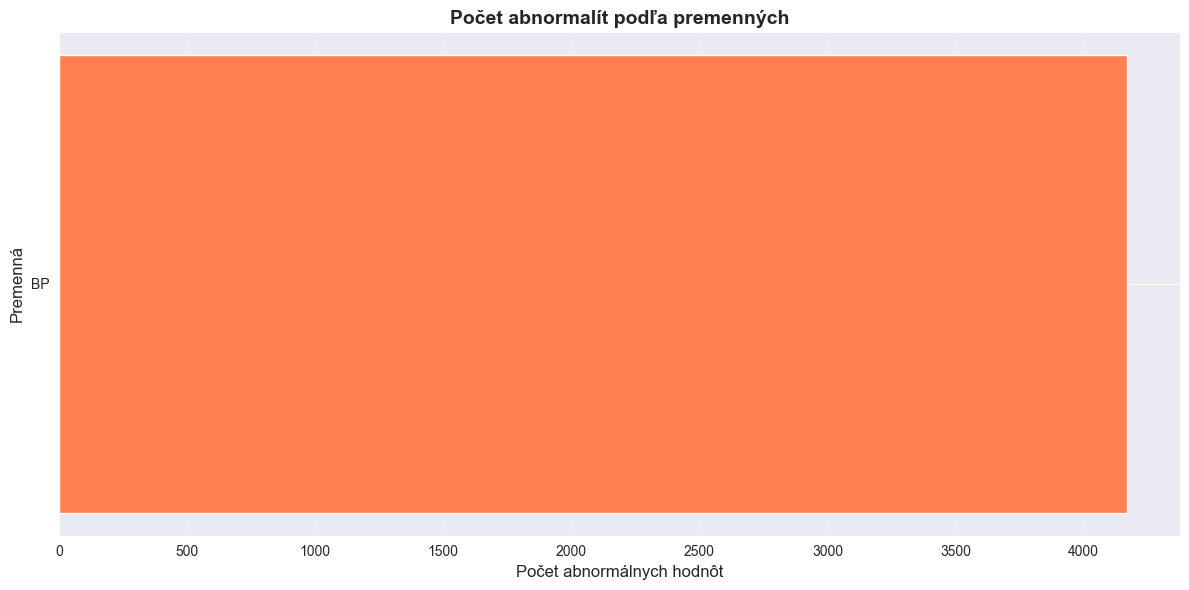


Percentuálny podiel abnormalít:


,total,abnormal,percentage
BP,12042.0,4168.0,34.612191
SpO₂,12042.0,0.0,0.000000
HR,12042.0,0.0,0.000000
PI,12042.0,0.0,0.000000
RR,12042.0,0.0,0.000000
EtCO₂,12042.0,0.0,0.000000
FiO₂,12042.0,0.0,0.000000
PRV,12042.0,0.0,0.000000
PVI,12042.0,0.0,0.000000
Hb level,12042.0,0.0,0.000000


In [80]:
normal_ranges = {
    'SpO₂': (95, 100),
    'HR': (60, 100),
    'PI': (0.2, 20),
    'RR': (12, 20),
    'EtCO₂': (35, 45),
    'FiO₂': (21, 100),
    'PRV': (20, 200),
    'BP': (70, 105),  # Mean Arterial Pressure (MAP)
    'Skin_Temperature': (33, 38),
    'PVI': (10, 20),
    'Hb level': (12, 18),
    'SV': (60, 100),
    'CO': (4, 8),
    'O₂_extraction_ratio': (0.2, 0.3),
    'SNR': (20, 40),
    'Signal_Quality_Index': (0, 100)
}
def detect_abnormal_values(df):
    abnormal_records = []

    for idx, row in df.iterrows():
        abnormalities = []

        for var, (min_val, max_val) in normal_ranges.items():
            if var in df.columns:
                value = row[var]
                if pd.notna(value):
                    try:
                        value = float(value)
                        if value < min_val or value > max_val:
                            abnormalities.append({
                                'variable': var,
                                'value': value,
                                'expected_range': f"{min_val}–{max_val}",
                                'deviation': 'nízka' if value < min_val else 'vysoká'
                            })
                    except (ValueError, TypeError):
                        pass

        if abnormalities:
            abnormal_records.append({
                'index': idx,
                'abnormalities': abnormalities
            })

    return abnormal_records

abnormal_records = detect_abnormal_values(observation_df)


if not abnormal_records:
    print("\nVšetky hodnoty sú v normálnom rozsahu!")
else:
    print(f"\nPočet záznamov s abnormálnymi hodnotami: {len(abnormal_records)} z {len(observation_df)}")
    print(f"Percento abnormálnych záznamov: {len(abnormal_records)/len(observation_df)*100:.1f}%\n")

    var_count = {}
    for record in abnormal_records:
        for abn in record['abnormalities']:
            var = abn['variable']
            var_count[var] = var_count.get(var, 0) + 1

    print("POČET ABNORMALÍT PODĽA PREMENNÝCH:")
    print("-" * 60)
    for var, count in sorted(var_count.items(), key=lambda x: x[1], reverse=True):
        print(f"  {var:30s}: {count:3d} abnormálnych hodnôt")

if abnormal_records:
    print("\n" + "="*80)
    print("DETAILNÝ ZOZNAM ABNORMÁLNYCH ZÁZNAMOV (prvých 20):")
    print("="*80)

    for record in abnormal_records[:20]:
        print(f"\nZáznam #{record['index']}:")
        for abn in record['abnormalities']:
            print(f"  • {abn['variable']:20s}: {abn['value']:8.2f} ({abn['deviation']}) "
                  f"[norma: {abn['expected_range']}]")

    if len(abnormal_records) > 20:
        print(f"\n... a ďalších {len(abnormal_records)-20} záznamov")
if abnormal_records:
    var_count = {}
    for record in abnormal_records:
        for abn in record['abnormalities']:
            var = abn['variable']
            var_count[var] = var_count.get(var, 0) + 1

    if var_count:
        plt.figure(figsize=(12, 6))
        vars_sorted = sorted(var_count.items(), key=lambda x: x[1], reverse=True)
        variables = [v[0] for v in vars_sorted]
        counts = [v[1] for v in vars_sorted]

        plt.barh(variables, counts, color='coral')
        plt.xlabel('Počet abnormálnych hodnôt', fontsize=12)
        plt.ylabel('Premenná', fontsize=12)
        plt.title('Počet abnormalít podľa premenných', fontsize=14, fontweight='bold')
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()

# %%
# Percentuálny podiel abnormalít pre každú premennú
if abnormal_records:
    var_stats = {}
    for var in normal_ranges.keys():
        if var in observation_df.columns:
            total = observation_df[var].notna().sum()
            abnormal = var_count.get(var, 0)
            if total > 0:
                var_stats[var] = {
                    'total': total,
                    'abnormal': abnormal,
                    'percentage': (abnormal / total) * 100
                }

    stats_df = pd.DataFrame(var_stats).T
    stats_df = stats_df.sort_values('percentage', ascending=False)

    print("\nPercentuálny podiel abnormalít:")
    print("="*60)
    display(stats_df)

🔍 Spúšťam detekciu nelogických dátových vzťahov...

REPORT: NELOGICKÉ DÁTOVÉ VZŤAHY

⚠ Počet záznamov s nelogickými vzťahmi: 12027 z 12042
⚠ Percento problematických záznamov: 99.9%

POČET PROBLÉMOV PODĽA TYPU:
------------------------------------------------------------
  Matematický nesúlad                : 12027 problémov
  Technická anomália                 :   1 problémov

POČET PROBLÉMOV PODĽA ZÁVAŽNOSTI:
------------------------------------------------------------
  Vysoká    : 12027 problémov
  Stredná   :   0 problémov
  Nízka     :   1 problémov

DETAILNÝ ZOZNAM NELOGICKÝCH VZŤAHOV (prvých 15):

📍 Záznam #0:
  🔴 [Matematický nesúlad] CO=4.01 L/min, ale HR×SV=5.70 L/min
     Závažnosť: vysoká

📍 Záznam #1:
  🔴 [Matematický nesúlad] CO=4.10 L/min, ale HR×SV=6.48 L/min
     Závažnosť: vysoká

📍 Záznam #2:
  🔴 [Matematický nesúlad] CO=4.04 L/min, ale HR×SV=6.34 L/min
     Závažnosť: vysoká

📍 Záznam #3:
  🔴 [Matematický nesúlad] CO=4.10 L/min, ale HR×SV=6.57 L/min
     Závažnosť:

,SpO₂,HR,PI,RR,EtCO₂,FiO₂,PRV,BP,Skin Temperature,Motion/Activity index,...,Blood Flow Index,PPG waveform features,Signal Quality Index,Respiratory effort,O₂ extraction ratio,SNR,oximetry,latitude,longitude,Issues
0,97.483488,69.471352,9.911564,15.329319,38.178027,60.101846,148.567376,96.208861,34.226015,11.729937,...,34.679832,69.068760,57.483314,45.758856,0.232423,25.714366,1.0,-38.16604,145.13643,"[Matematický nesúlad] CO=4.01 L/min, ale HR×SV..."
1,97.902093,80.851726,15.588303,17.275079,39.646854,75.668908,123.879495,98.137022,33.668431,10.161811,...,54.072677,64.324605,66.263554,32.794886,0.263252,23.649392,1.0,31.92923,34.86563,"[Matematický nesúlad] CO=4.10 L/min, ale HR×SV..."
2,96.752904,76.348559,8.953510,16.430277,36.947676,65.740531,108.444329,97.414632,36.068788,9.267287,...,48.383117,63.555447,62.444904,63.341514,0.222042,30.793751,0.0,36.75965,137.36215,"[Matematický nesúlad] CO=4.04 L/min, ale HR×SV..."
3,96.294252,80.987366,4.620207,16.421542,41.095814,67.512131,102.937951,97.990286,36.157136,7.918658,...,63.089082,59.969163,32.389461,47.606476,0.249341,32.439713,0.0,51.47810,57.35520,"[Matematický nesúlad] CO=4.10 L/min, ale HR×SV..."
4,96.119512,77.806695,4.241959,16.563798,40.035932,77.913631,115.771828,107.252089,36.530143,9.987053,...,63.227829,67.475084,61.033048,33.579243,0.299835,30.603965,0.0,22.47110,88.14530,"[Matematický nesúlad] CO=4.06 L/min, ale HR×SV..."
5,97.817026,84.055645,10.169989,15.731240,40.905026,83.929059,101.251040,104.758027,34.508687,10.029014,...,70.460761,37.359324,56.740731,44.183779,0.246869,24.560341,1.0,42.06166,-1.60452,"[Matematický nesúlad] CO=4.18 L/min, ale HR×SV..."
6,95.902354,79.129505,4.840933,17.579668,39.747100,53.630021,141.505019,105.542844,36.833724,10.894904,...,47.282322,38.681206,52.889366,43.526622,0.239671,30.690374,0.0,11.86590,34.38690,"[Matematický nesúlad] CO=4.07 L/min, ale HR×SV..."
7,97.428648,86.455910,10.436751,14.583745,38.005091,69.894825,121.294055,98.894182,35.387845,9.012965,...,32.953323,73.155931,76.843696,51.258950,0.211304,36.469579,0.0,38.96372,-76.99081,"[Matematický nesúlad] CO=4.30 L/min, ale HR×SV..."
8,96.367300,78.513350,12.480662,15.637585,39.166775,61.018901,111.710204,109.593984,36.078901,10.764040,...,35.722872,63.314790,82.697329,36.119130,0.212087,25.157896,1.0,-5.41667,38.01667,"[Matematický nesúlad] CO=4.06 L/min, ale HR×SV..."
9,98.443411,83.648027,5.881146,16.554055,40.500567,64.245695,96.627517,100.763859,36.411654,11.262285,...,53.703017,65.631762,42.814922,44.894341,0.231964,35.563730,1.0,33.43443,-5.22126,"[Matematický nesúlad] CO=4.17 L/min, ale HR×SV..."



✓ Záznamy s nelogickými vzťahmi uložené do: illogical_relationships.csv


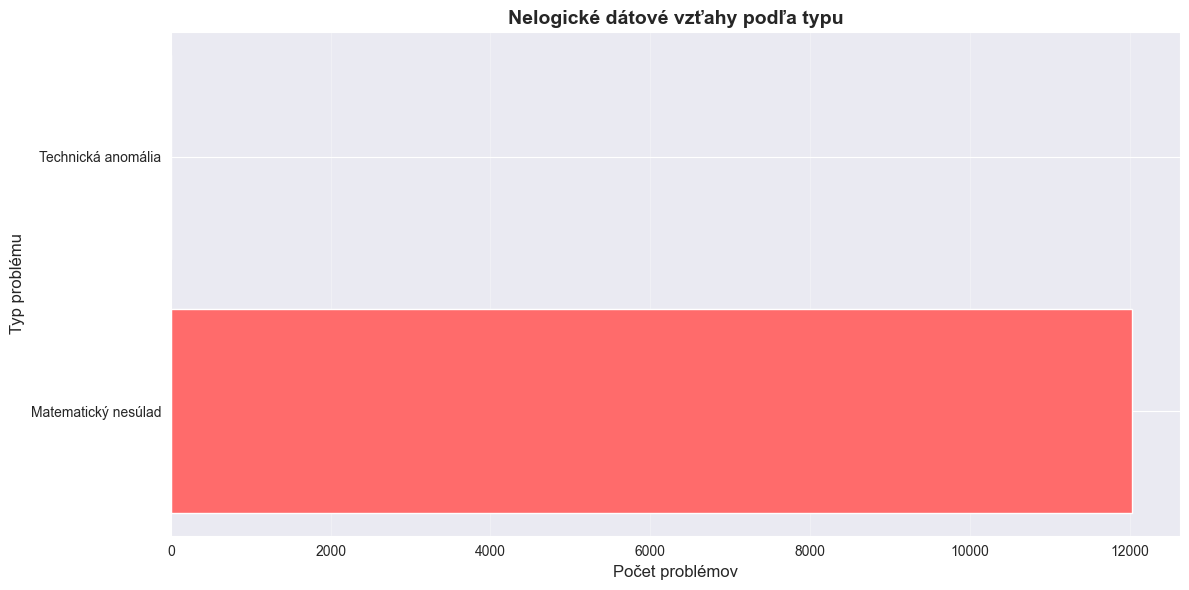

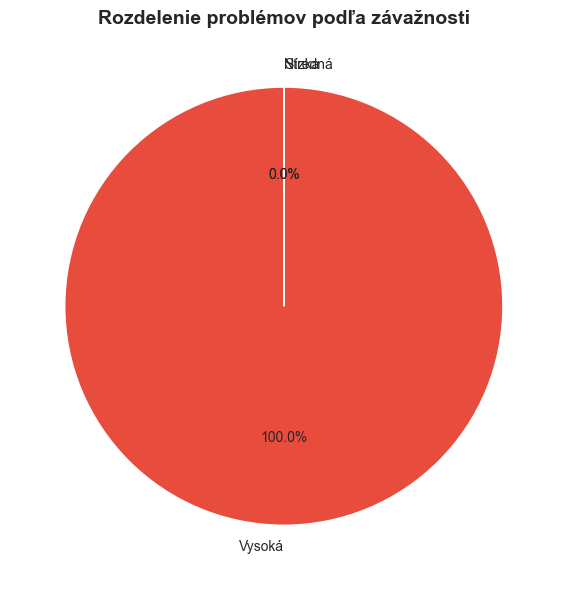

In [78]:
def check_illogical_relationships(df):
    illogical_records = []

    for idx, row in df.iterrows():
        issues = []

        # 1. MATEMATICKÉ VZŤAHY
        # Cardiac Output = Heart Rate × Stroke Volume (v L/min)
        if all(pd.notna(row[col]) for col in ['CO', 'HR', 'SV'] if col in df.columns):
            calculated_co = (row['HR'] * row['SV']) / 1000  # SV je v mL, CO v L
            actual_co = row['CO']
            error_percent = abs(calculated_co - actual_co) / actual_co * 100

            if error_percent > 15:  # Viac ako 15% rozdiel
                issues.append({
                    'type': 'Matematický nesúlad',
                    'description': f"CO={actual_co:.2f} L/min, ale HR×SV={(row['HR']*row['SV'])/1000:.2f} L/min",
                    'severity': 'vysoká'
                })

        # 2. FYZIOLOGICKÉ PROTIREČENIA

        # Hypoxémia (nízke SpO₂) s normálnym srdcovým tepom
        if all(pd.notna(row[col]) for col in ['SpO₂', 'HR'] if col in df.columns):
            if row['SpO₂'] < 90 and 60 <= row['HR'] <= 80:
                issues.append({
                    'type': 'Fyziologické protirečenie',
                    'description': f"Nízke SpO₂={row['SpO₂']:.1f}% ale normálny HR={row['HR']:.0f} bpm (malo by byť tachykardia)",
                    'severity': 'stredná'
                })

        # Vysoké EtCO₂ (hyperkapnia) s normálnou dychovou frekvenciou
        if all(pd.notna(row[col]) for col in ['EtCO₂', 'RR'] if col in df.columns):
            if row['EtCO₂'] > 50 and 12 <= row['RR'] <= 16:
                issues.append({
                    'type': 'Fyziologické protirečenie',
                    'description': f"Vysoké EtCO₂={row['EtCO₂']:.1f} mmHg ale normálny RR={row['RR']:.0f} (mala by byť hyperventlácia)",
                    'severity': 'stredná'
                })

        # Nízke EtCO₂ (hypokapnia) s normálnou dychovou frekvenciou
        if all(pd.notna(row[col]) for col in ['EtCO₂', 'RR'] if col in df.columns):
            if row['EtCO₂'] < 30 and 12 <= row['RR'] <= 16:
                issues.append({
                    'type': 'Fyziologické protirečenie',
                    'description': f"Nízke EtCO₂={row['EtCO₂']:.1f} mmHg ale normálny RR={row['RR']:.0f} (pravdepodobne hyperventlácia)",
                    'severity': 'nízka'
                })

        # Anémia (nízky Hb) s normálnym srdcovým tepom
        if all(pd.notna(row[col]) for col in ['Hb level', 'HR'] if col in df.columns):
            if row['Hb level'] < 10 and 60 <= row['HR'] <= 80:
                issues.append({
                    'type': 'Fyziologické protirečenie',
                    'description': f"Nízky Hb={row['Hb level']:.1f} g/dL ale normálny HR={row['HR']:.0f} bpm (mala by byť kompenzačná tachykardia)",
                    'severity': 'stredná'
                })

        # Vysoké FiO₂ ale nízke SpO₂
        if all(pd.notna(row[col]) for col in ['FiO₂', 'SpO₂'] if col in df.columns):
            if row['FiO₂'] > 60 and row['SpO₂'] < 92:
                issues.append({
                    'type': 'Fyziologické protirečenie',
                    'description': f"Vysoké FiO₂={row['FiO₂']:.1f}% ale nízke SpO₂={row['SpO₂']:.1f}% (závažná hypoxémia napriek kyslíku)",
                    'severity': 'vysoká'
                })

        # Nízke FiO₂ ale vysoké SpO₂
        if all(pd.notna(row[col]) for col in ['FiO₂', 'SpO₂'] if col in df.columns):
            if row['FiO₂'] < 30 and row['SpO₂'] > 98:
                issues.append({
                    'type': 'Možná anomália',
                    'description': f"Nízke FiO₂={row['FiO₂']:.1f}% ale vysoké SpO₂={row['SpO₂']:.1f}% (nezvyčajné)",
                    'severity': 'nízka'
                })

        # 3. TECHNICKÉ ANOMÁLIE

        # Dobrý signal quality ale extrémne hodnoty
        if 'Signal_Quality_Index' in df.columns and pd.notna(row['Signal_Quality_Index']):
            if row['Signal_Quality_Index'] > 80:
                # Kontrola extrémnych hodnôt pri dobrom signáli
                if 'HR' in df.columns and pd.notna(row['HR']):
                    if row['HR'] < 40 or row['HR'] > 150:
                        issues.append({
                            'type': 'Technická anomália',
                            'description': f"Dobrý signal quality ({row['Signal_Quality_Index']:.0f}) ale extrémny HR={row['HR']:.0f} bpm",
                            'severity': 'stredná'
                        })

        # Vysoký perfusion index ale nízka saturácia
        if all(pd.notna(row[col]) for col in ['PI', 'SpO₂'] if col in df.columns):
            if row['PI'] > 5 and row['SpO₂'] < 90:
                issues.append({
                    'type': 'Technická anomália',
                    'description': f"Vysoký PI={row['PI']:.1f}% (dobrá perfúzia) ale nízke SpO₂={row['SpO₂']:.1f}%",
                    'severity': 'stredná'
                })

        # Nízky perfusion index ale normálne hodnoty
        if all(pd.notna(row[col]) for col in ['PI', 'SpO₂', 'HR'] if col in df.columns):
            if row['PI'] < 0.5 and 95 <= row['SpO₂'] <= 100 and 60 <= row['HR'] <= 100:
                issues.append({
                    'type': 'Technická anomália',
                    'description': f"Veľmi nízky PI={row['PI']:.2f}% (slabý signál) ale normálne hodnoty - možný artefakt",
                    'severity': 'nízka'
                })

        # 4. HEMODYNAMICKÉ VZŤAHY

        # Nízky krvný tlak ale normálny cardiac output
        if all(pd.notna(row[col]) for col in ['BP', 'CO'] if col in df.columns):
            if row['BP'] < 70 and 4 <= row['CO'] <= 6:
                issues.append({
                    'type': 'Hemodynamické protirečenie',
                    'description': f"Nízky BP={row['BP']:.1f} mmHg ale normálny CO={row['CO']:.1f} L/min (mala by byť vazodilatácia)",
                    'severity': 'stredná'
                })

        # Vysoký cardiac output ale normálny heart rate
        if all(pd.notna(row[col]) for col in ['CO', 'HR'] if col in df.columns):
            if row['CO'] > 8 and 60 <= row['HR'] <= 80:
                issues.append({
                    'type': 'Hemodynamické protirečenie',
                    'description': f"Vysoký CO={row['CO']:.1f} L/min ale normálny HR={row['HR']:.0f} bpm (nezvyčajné)",
                    'severity': 'stredná'
                })

        if issues:
            illogical_records.append({
                'index': idx,
                'issues': issues
            })

    return illogical_records

illogical_records = check_illogical_relationships(observation_df)

print("REPORT: NELOGICKÉ DÁTOVÉ VZŤAHY")

if not illogical_records:
    print("\nNenašli sa žiadne nelogické vzťahy medzi dátami!")
else:
    print(f"\nPočet záznamov s nelogickými vzťahmi: {len(illogical_records)} z {len(observation_df)}")
    print(f"Percento problematických záznamov: {len(illogical_records)/len(observation_df)*100:.1f}%\n")

    type_count = {}
    severity_count = {'vysoká': 0, 'stredná': 0, 'nízka': 0}

    for record in illogical_records:
        for issue in record['issues']:
            issue_type = issue['type']
            type_count[issue_type] = type_count.get(issue_type, 0) + 1
            severity_count[issue['severity']] += 1

    print("POČET PROBLÉMOV PODĽA TYPU:")
    print("-" * 60)
    for itype, count in sorted(type_count.items(), key=lambda x: x[1], reverse=True):
        print(f"  {itype:35s}: {count:3d} problémov")

    print("\nPOČET PROBLÉMOV PODĽA ZÁVAŽNOSTI:")
    print("-" * 60)
    for severity in ['vysoká', 'stredná', 'nízka']:
        count = severity_count[severity]
        print(f"  {severity.capitalize():10s}: {count:3d} problémov")

if illogical_records:
    print("\n" + "="*80)
    print("DETAILNÝ ZOZNAM NELOGICKÝCH VZŤAHOV (prvých 15):")
    print("="*80)

    for record in illogical_records[:15]:
        print(f"\nZáznam #{record['index']}:")
        for issue in record['issues']:
            print(f"[{issue['type']}] {issue['description']}")
            print(f"Závažnosť: {issue['severity']}")

    if len(illogical_records) > 15:
        print(f"\n... a ďalších {len(illogical_records)-15} záznamov")

if illogical_records:
    illogical_indices = [r['index'] for r in illogical_records]
    illogical_df = observation_df.loc[illogical_indices].copy()

    # Pridanie stĺpca s popisom problémov
    issues_desc = []
    for record in illogical_records:
        desc = " | ".join([f"[{i['type']}] {i['description']}" for i in record['issues']])
        issues_desc.append(desc)

    illogical_df['Issues'] = issues_desc

    print("\nDataFrame s nelogickými vzťahmi:")
    display(illogical_df.head(10))

    # Uloženie do CSV
    illogical_df.to_csv('illogical_relationships.csv', index=False)
    print(f"\nZáznamy s nelogickými vzťahmi uložené do: illogical_relationships.csv")

# %%
# Vizualizácia
if illogical_records:
    import matplotlib.pyplot as plt

    # Graf podľa typu problému
    if type_count:
        plt.figure(figsize=(12, 6))
        types_sorted = sorted(type_count.items(), key=lambda x: x[1], reverse=True)
        types = [t[0] for t in types_sorted]
        counts = [t[1] for t in types_sorted]

        colors = ['#ff6b6b', '#feca57', '#48dbfb', '#1dd1a1', '#a29bfe']
        plt.barh(types, counts, color=colors[:len(types)])
        plt.xlabel('Počet problémov', fontsize=12)
        plt.ylabel('Typ problému', fontsize=12)
        plt.title('Nelogické dátové vzťahy podľa typu', fontsize=14, fontweight='bold')
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()

    # Graf podľa závažnosti
    plt.figure(figsize=(8, 6))
    severities = ['Vysoká', 'Stredná', 'Nízka']
    counts_sev = [severity_count['vysoká'], severity_count['stredná'], severity_count['nízka']]
    colors_sev = ['#e74c3c', '#f39c12', '#2ecc71']

    plt.pie(counts_sev, labels=severities, autopct='%1.1f%%', colors=colors_sev, startangle=90)
    plt.title('Rozdelenie problémov podľa závažnosti', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

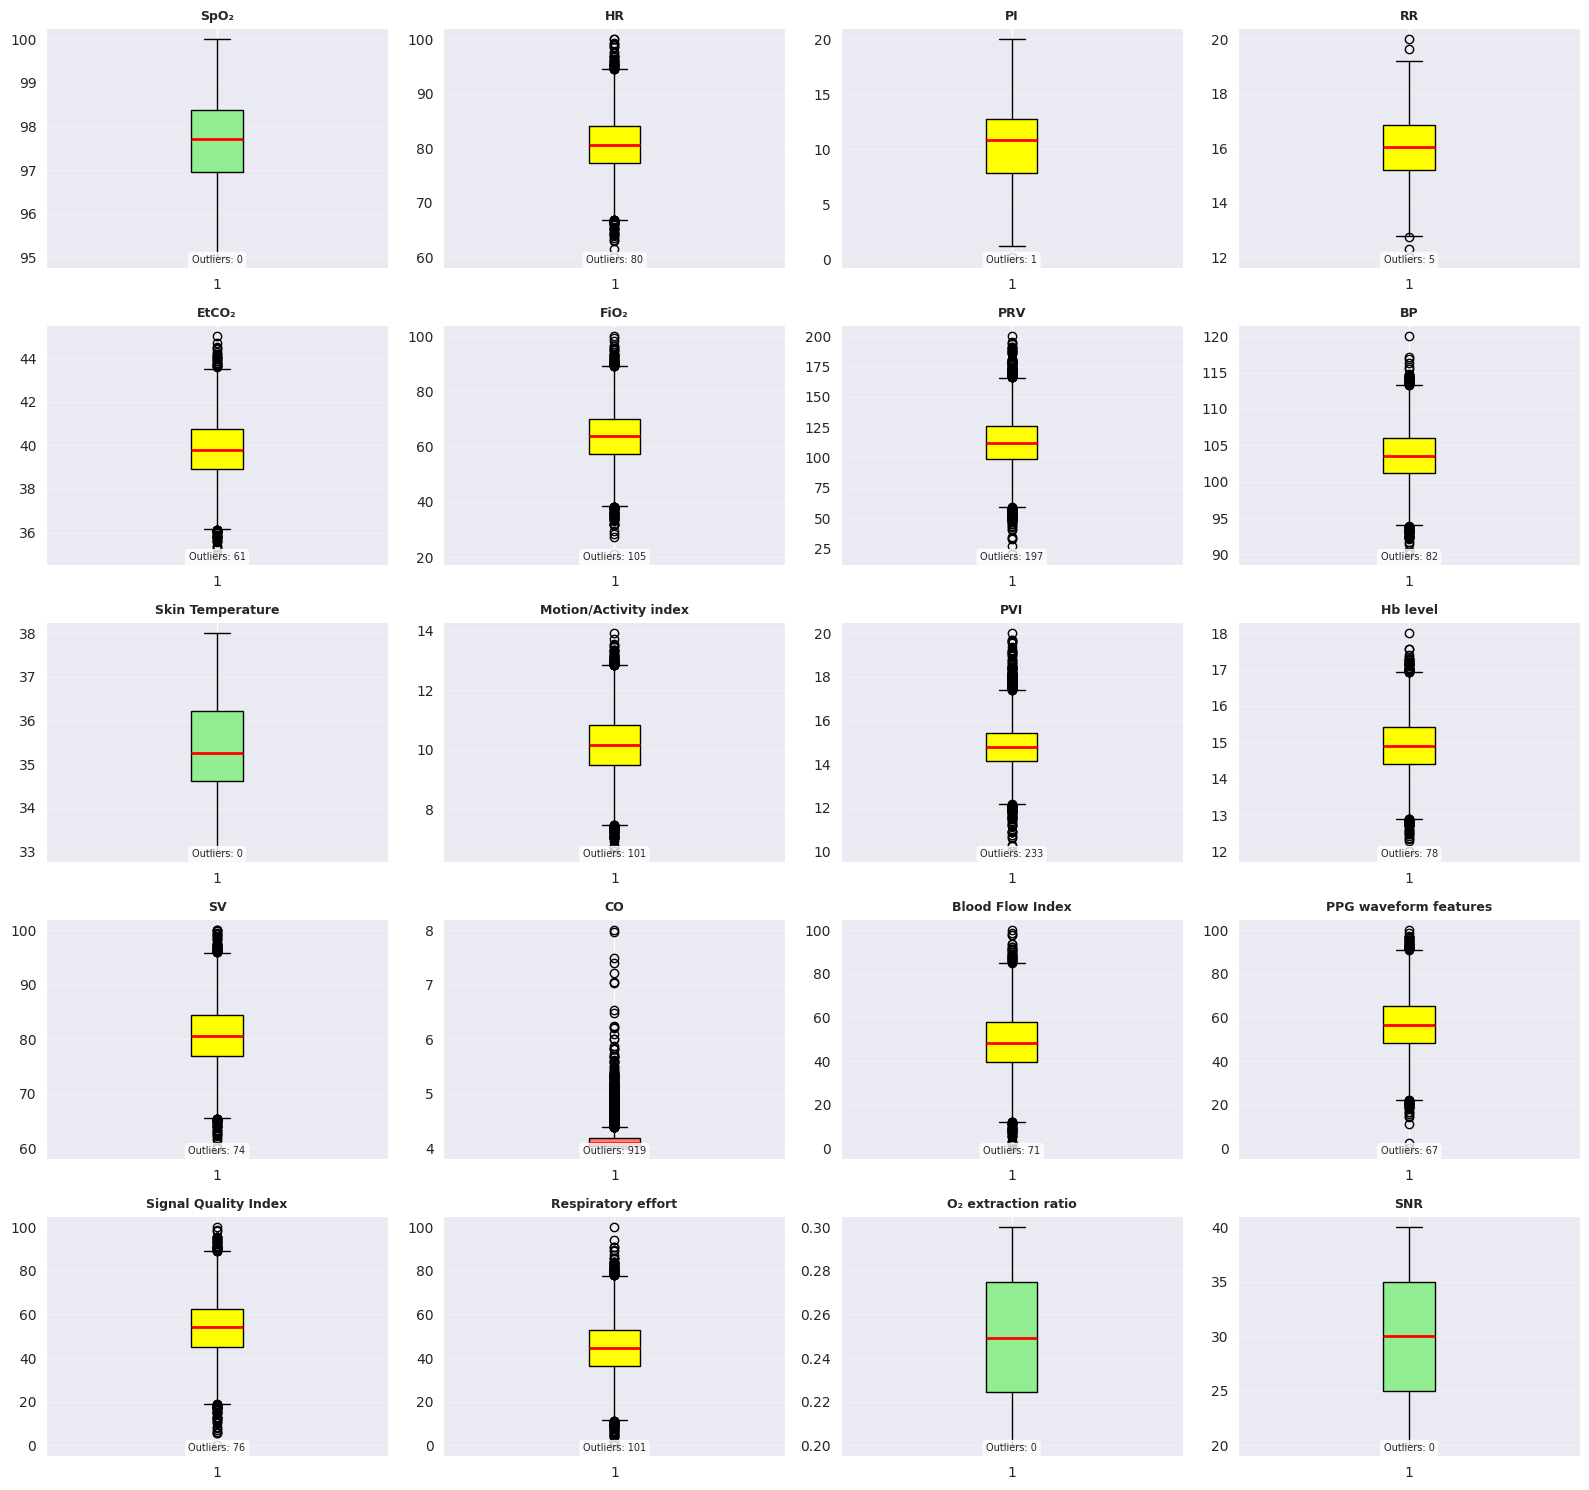


SUMÁR OUTLIEROV

               Stĺpec     N  Outliers  Percent  Lower_bound  Upper_bound
                   CO 12042       919 7.631623     3.841704     4.396914
                  PVI 12042       233 1.934895    12.157175    17.403966
                  PRV 12042       197 1.635941    58.834452   165.824824
                 FiO₂ 12042       105 0.871948    38.339438    89.285245
Motion/Activity index 12042       101 0.838731     7.476949    12.836727
   Respiratory effort 12042       101 0.838731    11.461798    77.873137
                   BP 12042        82 0.680950    93.948056   113.255709
                   HR 12042        80 0.664341    66.928265    94.483178
             Hb level 12042        78 0.647733    12.901743    16.925048
 Signal Quality Index 12042        76 0.631124    18.899933    89.054952
                   SV 12042        74 0.614516    65.585666    95.831648
     Blood Flow Index 12042        71 0.589603    12.122565    85.121641
PPG waveform features 12042      

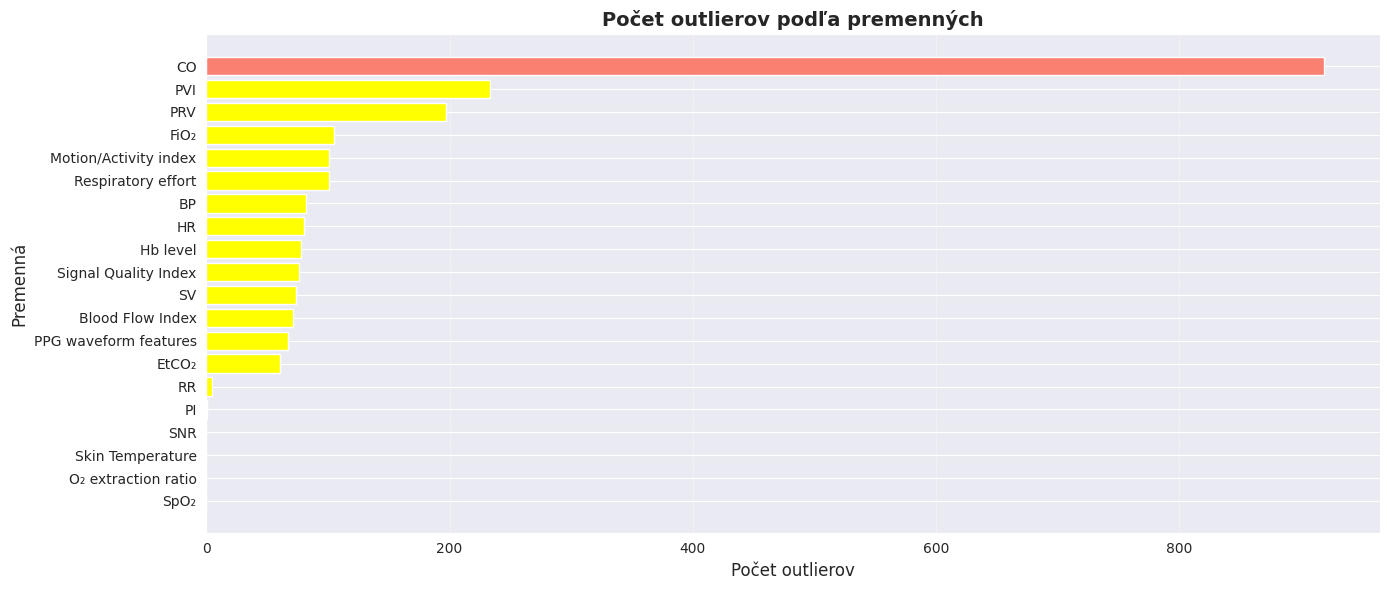

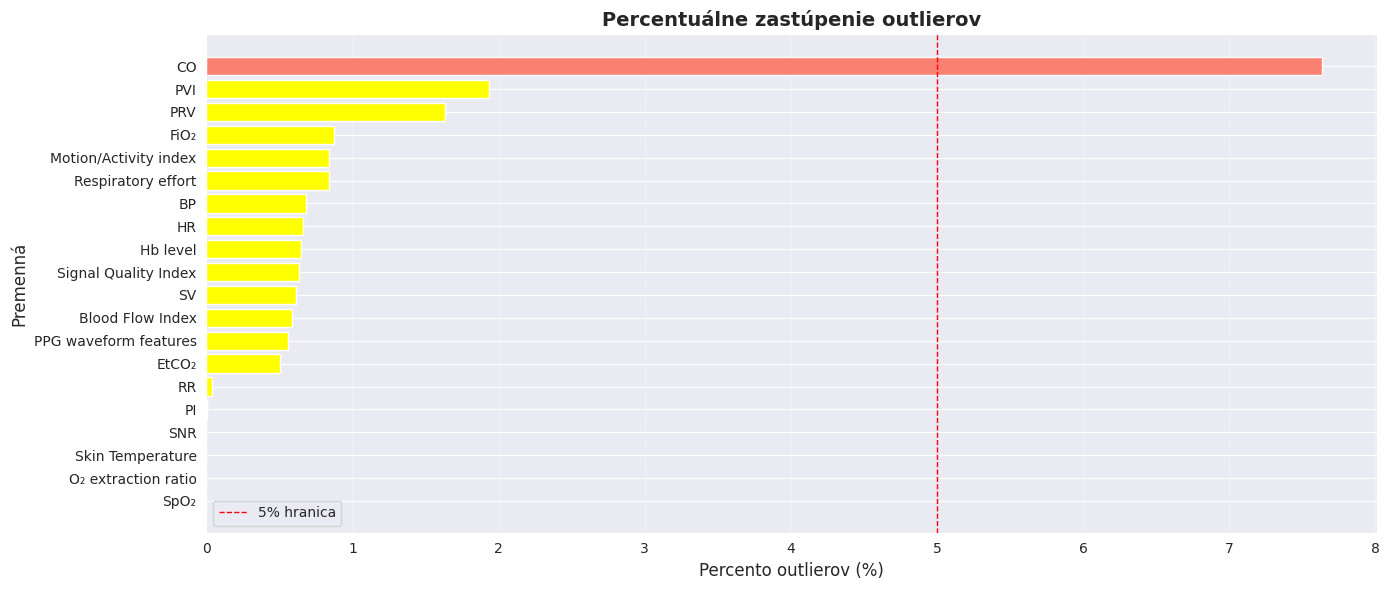

In [9]:
exclude_columns = ['latitude', 'longitude', 'oximetry']

numeric_columns = observation_df.select_dtypes(include=[np.number]).columns.tolist()
columns_to_plot = [col for col in numeric_columns if col not in exclude_columns]
plt.rcParams['font.family'] = 'DejaVu Sans'
def create_boxplots(df, columns, figsize_per_plot=(4, 3)):
    valid_columns = [col for col in columns if col in df.columns and df[col].notna().sum() > 0]


    n_cols = 4  # 4 grafy na riadok
    n_rows = int(np.ceil(len(valid_columns) / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize_per_plot[0]*n_cols, figsize_per_plot[1]*n_rows))

    if n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_rows == 0:
        return

    outlier_summary = []

    for idx, col in enumerate(valid_columns):
        row = idx // n_cols
        col_idx = idx % n_cols
        ax = axes[row, col_idx]

        data = df[col].dropna()

        if len(data) > 0:
            # Boxplot
            bp = ax.boxplot(data, vert=True, patch_artist=True)
            bp['boxes'][0].set_facecolor('lightblue')
            bp['medians'][0].set_color('red')
            bp['medians'][0].set_linewidth(2)

            ax.set_title(f'{col}', fontsize=9, fontweight='bold')
            ax.grid(True, alpha=0.3, axis='y')

            # Počet outlierov
            Q1 = data.quantile(0.25)
            Q3 = data.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5*IQR
            upper_bound = Q3 + 1.5*IQR
            outliers = data[(data < lower_bound) | (data > upper_bound)]
            n_outliers = len(outliers)

            # Farba podľa počtu outlierov
            if n_outliers == 0:
                color = 'lightgreen'
            elif n_outliers < len(data) * 0.05:  # Menej ako 5%
                color = 'yellow'
            else:  # Viac ako 5%
                color = 'salmon'

            bp['boxes'][0].set_facecolor(color)

            ax.text(0.5, 0.02, f'Outliers: {n_outliers}',
                   transform=ax.transAxes, fontsize=7,
                   ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

            # Uloženie štatistík
            outlier_summary.append({
                'Stĺpec': col,
                'N': len(data),
                'Outliers': n_outliers,
                'Percent': (n_outliers / len(data)) * 100,
                'Q1': Q1,
                'Q3': Q3,
                'IQR': IQR,
                'Lower_bound': lower_bound,
                'Upper_bound': upper_bound
            })
        else:
            ax.text(0.5, 0.5, 'Žiadne dáta', ha='center', va='center')
            ax.set_title(f'{col}', fontsize=9)

    # Skrytie prázdnych subplotov
    for idx in range(len(valid_columns), n_rows * n_cols):
        row = idx // n_cols
        col_idx = idx % n_cols
        axes[row, col_idx].set_visible(False)

    plt.tight_layout()
    plt.show()

    return outlier_summary

outlier_summary = create_boxplots(observation_df, columns_to_plot)

# %%
# Tabuľka so štatistikami outlierov
if outlier_summary:
    print("\n" + "="*80)
    print("SUMÁR OUTLIEROV")
    print("="*80 + "\n")

    outlier_df = pd.DataFrame(outlier_summary)
    outlier_df = outlier_df.sort_values('Outliers', ascending=False)

    print(outlier_df[['Stĺpec', 'N', 'Outliers', 'Percent', 'Lower_bound', 'Upper_bound']].to_string(index=False))

    # Stĺpce s najväčším počtom outlierov
    print("\n" + "="*80)
    print("TOP 10 STĹPCOV S NAJVÄČŠÍM POČTOM OUTLIEROV")
    print("="*80 + "\n")

    top_outliers = outlier_df.head(10)
    for idx, row in top_outliers.iterrows():
        print(f"  {row['Stĺpec']:30s}: {row['Outliers']:4.0f} outliers ({row['Percent']:5.1f}%)")

    # Celkové štatistiky
    total_outliers = outlier_df['Outliers'].sum()
    total_values = outlier_df['N'].sum()

    print("\n" + "="*80)
    print("CELKOVÉ ŠTATISTIKY")
    print("="*80)
    print(f"  Celkový počet hodnôt:        {total_values:,}")
    print(f"  Celkový počet outlierov:     {total_outliers:,}")
    print(f"  Priemerné % outlierov:       {(total_outliers/total_values)*100:.2f}%")
    print(f"  Stĺpce bez outlierov:        {len(outlier_df[outlier_df['Outliers'] == 0])}")
    print(f"  Stĺpce s outliermi:          {len(outlier_df[outlier_df['Outliers'] > 0])}")

# %%
# Graf rozdelenia outlierov
if outlier_summary:
    outlier_df = pd.DataFrame(outlier_summary)

    # Graf počtu outlierov
    plt.figure(figsize=(14, 6))

    # Zoradenie podľa počtu outlierov
    outlier_df_sorted = outlier_df.sort_values('Outliers', ascending=True)

    colors = ['lightgreen' if x == 0 else 'yellow' if x < outlier_df_sorted['N'].iloc[0]*0.05 else 'salmon'
              for x in outlier_df_sorted['Outliers']]

    plt.barh(outlier_df_sorted['Stĺpec'], outlier_df_sorted['Outliers'], color=colors)
    plt.xlabel('Počet outlierov', fontsize=12)
    plt.ylabel('Premenná', fontsize=12)
    plt.title('Počet outlierov podľa premenných', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Graf percentuálneho zastúpenia
    plt.figure(figsize=(14, 6))

    colors = ['lightgreen' if x == 0 else 'yellow' if x < 5 else 'salmon'
              for x in outlier_df_sorted['Percent']]

    plt.barh(outlier_df_sorted['Stĺpec'], outlier_df_sorted['Percent'], color=colors)
    plt.xlabel('Percento outlierov (%)', fontsize=12)
    plt.ylabel('Premenná', fontsize=12)
    plt.title('Percentuálne zastúpenie outlierov', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    plt.axvline(x=5, color='red', linestyle='--', linewidth=1, label='5% hranica')
    plt.legend()
    plt.tight_layout()
    plt.show()

📊 Stĺpce na spracovanie: 10 z 10
✅ Dostupné stĺpce: ['CO', 'PVI', 'PRV', 'FiO₂', 'Motion/Activity index', 'Respiratory effort', 'BP', 'HR', 'Hb level', 'Signal Quality Index']

VARIANT 1: NAHRADENIE OUTLIEROV (WINSORIZATION)
Nastavenie: 5% - 95% percentil

ŠTATISTIKY NAHRADENÝCH HODNÔT:

               Stĺpec  N_original  N_lower_replaced  N_upper_replaced  N_total_replaced  Percent_replaced
                   CO       12042               603               603              1206         10.014948
                  PVI       12042               603               603              1206         10.014948
                  PRV       12042               603               603              1206         10.014948
                 FiO₂       12042               603               603              1206         10.014948
Motion/Activity index       12042               603               603              1206         10.014948
   Respiratory effort       12042               603               603      

/var/folders/v4/tyxh0md10wx2m9g4wys5cwl40000gn/T/ipykernel_4528/3099506834.py:181: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[2].boxplot(data_to_plot, labels=['PRED', 'PO'], patch_artist=True)


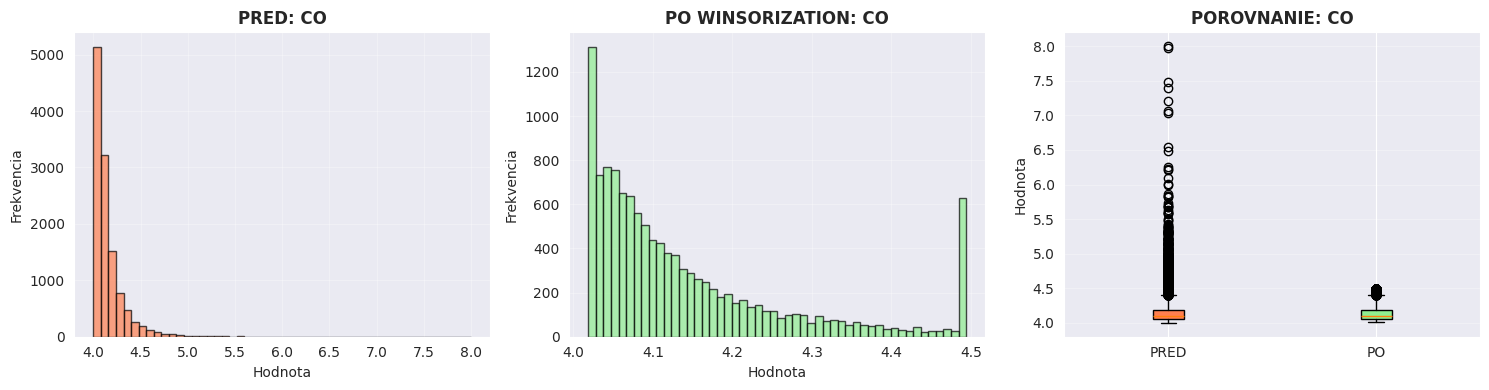

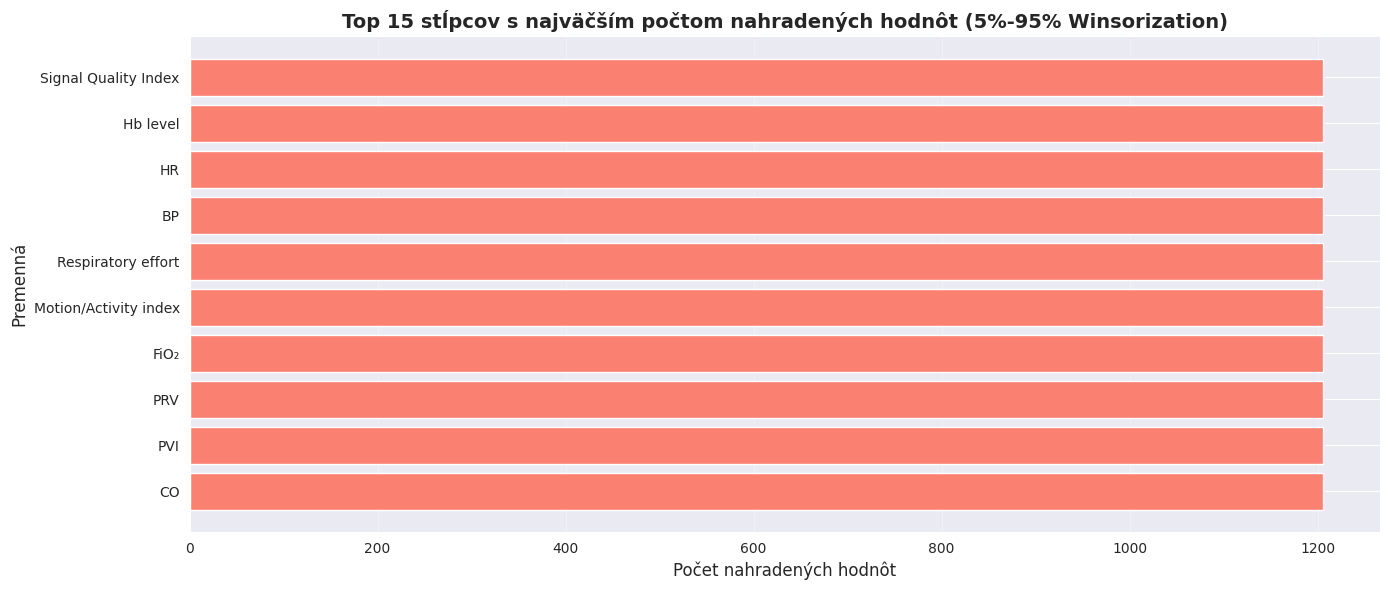

Winsorized dataset uložený: observation_winsorized.csv
Dataset s odstránenými outliermi uložený: observation_outliers_removed.csv
Štatistiky winsorization uložené: winsorization_stats.csv
Štatistiky odstránenia uložené: outlier_removal_stats.csv


In [10]:
plt.rcParams['font.family'] = 'DejaVu Sans'

columns_to_process = [
    'CO',
    'PVI',
    'PRV',
    'FiO₂',
    'Motion/Activity index',
    'Respiratory effort',
    'BP',
    'HR',
    'Hb level',
    'Signal Quality Index'
]

available_columns = [col for col in columns_to_process if col in observation_df.columns]
missing_columns = [col for col in columns_to_process if col not in observation_df.columns]

print(f"📊 Stĺpce na spracovanie: {len(available_columns)} z {len(columns_to_process)}")
print(f"✅ Dostupné stĺpce: {available_columns}")
if missing_columns:
    print(f"⚠️  Chýbajúce stĺpce: {missing_columns}")
print()

# windsorizacia
def winsorize_outliers(df, columns, lower_percentile=5, upper_percentile=95, inplace=False):
    if not inplace:
        df = df.copy()

    stats = []

    for col in columns:
        if col not in df.columns:
            continue

        original_data = df[col].dropna()
        n_original = len(original_data)

        if n_original == 0:
            continue

        lower_bound = df[col].quantile(lower_percentile / 100)
        upper_bound = df[col].quantile(upper_percentile / 100)

        lower_outliers = df[col] < lower_bound
        upper_outliers = df[col] > upper_bound
        n_lower = lower_outliers.sum()
        n_upper = upper_outliers.sum()
        n_total_replaced = n_lower + n_upper

        df.loc[lower_outliers, col] = lower_bound
        df.loc[upper_outliers, col] = upper_bound

        stats.append({
            'Stĺpec': col,
            'N_original': n_original,
            'Lower_bound': lower_bound,
            'Upper_bound': upper_bound,
            'N_lower_replaced': n_lower,
            'N_upper_replaced': n_upper,
            'N_total_replaced': n_total_replaced,
            'Percent_replaced': (n_total_replaced / n_original) * 100
        })

    return df, stats

# vymena outlierov za N/A
def remove_outliers(df, columns, lower_percentile=5, upper_percentile=95):
    df = df.copy()
    stats = []

    for col in columns:
        if col not in df.columns:
            continue

        # Počet pôvodných hodnôt
        original_data = df[col].dropna()
        n_original = len(original_data)

        if n_original == 0:
            continue

        # Výpočet percentilových hraníc
        lower_bound = df[col].quantile(lower_percentile / 100)
        upper_bound = df[col].quantile(upper_percentile / 100)

        # Identifikácia outlierov
        lower_outliers = df[col] < lower_bound
        upper_outliers = df[col] > upper_bound
        n_lower = lower_outliers.sum()
        n_upper = upper_outliers.sum()
        n_total_removed = n_lower + n_upper

        # Odstránenie outlierov (nastavenie na NaN)
        df.loc[lower_outliers | upper_outliers, col] = np.nan

        # Uloženie štatistík
        stats.append({
            'Stĺpec': col,
            'N_original': n_original,
            'Lower_bound': lower_bound,
            'Upper_bound': upper_bound,
            'N_lower_removed': n_lower,
            'N_upper_removed': n_upper,
            'N_total_removed': n_total_removed,
            'Percent_removed': (n_total_removed / n_original) * 100
        })

    return df, stats

print("VARIANT 1: NAHRADENIE OUTLIEROV (WINSORIZATION)")

# Nastavenie percentilových hraníc
LOWER_PERCENTILE = 5
UPPER_PERCENTILE = 95

print(f"Nastavenie: {LOWER_PERCENTILE}% - {UPPER_PERCENTILE}% percentil\n")

# Vytvorenie kópie datasetu
df_winsorized, stats_winsorized = winsorize_outliers(
    observation_df,
    available_columns,  # Použitie iba dostupných stĺpcov
    lower_percentile=LOWER_PERCENTILE,
    upper_percentile=UPPER_PERCENTILE
)
stats_df_wins = pd.DataFrame(stats_winsorized)
stats_df_wins = stats_df_wins.sort_values('N_total_replaced', ascending=False)

print("ŠTATISTIKY NAHRADENÝCH HODNÔT:\n")
print(stats_df_wins[['Stĺpec', 'N_original', 'N_lower_replaced', 'N_upper_replaced',
                      'N_total_replaced', 'Percent_replaced']].to_string(index=False))

total_replaced = stats_df_wins['N_total_replaced'].sum()
total_values = stats_df_wins['N_original'].sum()

print(f"Celkovo nahradených hodnôt: {total_replaced:,} z {total_values:,} ({(total_replaced/total_values)*100:.2f}%)")

print("VARIANT 2: ODSTRÁNENIE OUTLIEROV (NASTAVENIE NA NaN)")

df_removed, stats_removed = remove_outliers(
    observation_df,
    available_columns,  # Použitie iba dostupných stĺpcov
    lower_percentile=LOWER_PERCENTILE,
    upper_percentile=UPPER_PERCENTILE
)

stats_df_rem = pd.DataFrame(stats_removed)
stats_df_rem = stats_df_rem.sort_values('N_total_removed', ascending=False)

print("ŠTATISTIKY ODSTRÁNENÝCH HODNÔT:\n")
print(stats_df_rem[['Stĺpec', 'N_original', 'N_lower_removed', 'N_upper_removed',
                    'N_total_removed', 'Percent_removed']].to_string(index=False))

total_removed = stats_df_rem['N_total_removed'].sum()
total_values = stats_df_rem['N_original'].sum()

print(f"Celkovo odstránených hodnôt: {total_removed:,} z {total_values:,} ({(total_removed/total_values)*100:.2f}%)")

print("POROVNANIE: PRED vs PO WINSORIZATION")

top_column = stats_df_wins.iloc[0]['Stĺpec']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Histogram pred
axes[0].hist(observation_df[top_column].dropna(), bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[0].set_title(f'PRED: {top_column}', fontweight='bold')
axes[0].set_xlabel('Hodnota')
axes[0].set_ylabel('Frekvencia')
axes[0].grid(True, alpha=0.3)

# Histogram po
axes[1].hist(df_winsorized[top_column].dropna(), bins=50, color='lightgreen', alpha=0.7, edgecolor='black')
axes[1].set_title(f'PO WINSORIZATION: {top_column}', fontweight='bold')
axes[1].set_xlabel('Hodnota')
axes[1].set_ylabel('Frekvencia')
axes[1].grid(True, alpha=0.3)

# Boxplot porovnanie
data_to_plot = [observation_df[top_column].dropna(), df_winsorized[top_column].dropna()]
bp = axes[2].boxplot(data_to_plot, tick_labels=['PRED', 'PO'], patch_artist=True)
bp['boxes'][0].set_facecolor('coral')
bp['boxes'][1].set_facecolor('lightgreen')
axes[2].set_title(f'POROVNANIE: {top_column}', fontweight='bold')
axes[2].set_ylabel('Hodnota')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# %%
# Graf: Počet nahradených hodnôt podľa stĺpca
plt.figure(figsize=(14, 6))

top_n = 15  # Top 15 stĺpcov
top_stats = stats_df_wins.head(top_n)

colors = ['salmon' if x > 10 else 'yellow' if x > 5 else 'lightgreen' for x in top_stats['Percent_replaced']]

plt.barh(top_stats['Stĺpec'], top_stats['N_total_replaced'], color=colors)
plt.xlabel('Počet nahradených hodnôt', fontsize=12)
plt.ylabel('Premenná', fontsize=12)
plt.title(f'Top {top_n} stĺpcov s najväčším počtom nahradených hodnôt ({LOWER_PERCENTILE}%-{UPPER_PERCENTILE}% Winsorization)',
         fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

df_winsorized.to_csv('observation_winsorized.csv', index=False)
print(f"Winsorized dataset uložený: observation_winsorized.csv")

df_removed.to_csv('observation_outliers_removed.csv', index=False)
print(f"Dataset s odstránenými outliermi uložený: observation_outliers_removed.csv")

# Uloženie štatistík
stats_df_wins.to_csv('winsorization_stats.csv', index=False)
print(f"Štatistiky winsorization uložené: winsorization_stats.csv")

stats_df_rem.to_csv('outlier_removal_stats.csv', index=False)
print(f"Štatistiky odstránenia uložené: outlier_removal_stats.csv")